## Initialization

In [1]:
import seaborn as sns
import src.clustering as clust

sns.set_theme(style="whitegrid")

## Loading files & preprocessing

In [2]:
dim=64
data, major_labels, minor_labels = clust.load_data(stem=False, lemmatize=True, remove_conjunctions=False)
tfidf, w2v = clust.vectorize(data, w2v_options=dict(size=dim, iter=100, min_count=1)) # vectorization
pca_tfidf = clust.pca(dim, tfidf.toarray())

# Clustering
## KMeans
Evaluating hyper parameters:

In [3]:
variables = dict(n_components=list(range(2,16)), max_iter=[100, 300, 600], n_init=[5,10,15,20])
res = clust.probe_hyperparams(clust.kmeans, data=data, tfidf=pca_tfidf, w2v=w2v, variables=variables)

100%|██████████| 168/168 [01:35<00:00,  1.76it/s]


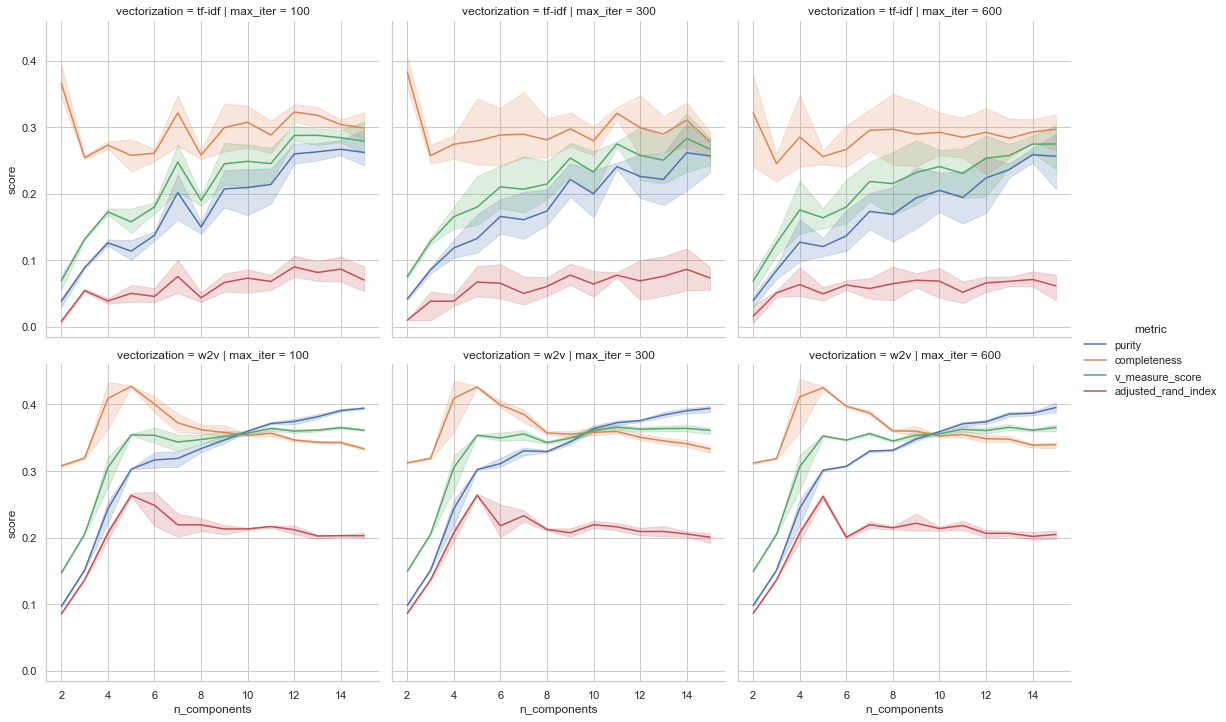

In [4]:
_ = sns.relplot(data=res, x='n_components', y='score', row='vectorization', col='max_iter', hue="metric", kind='line' )

Evaluating `n_components=13`:

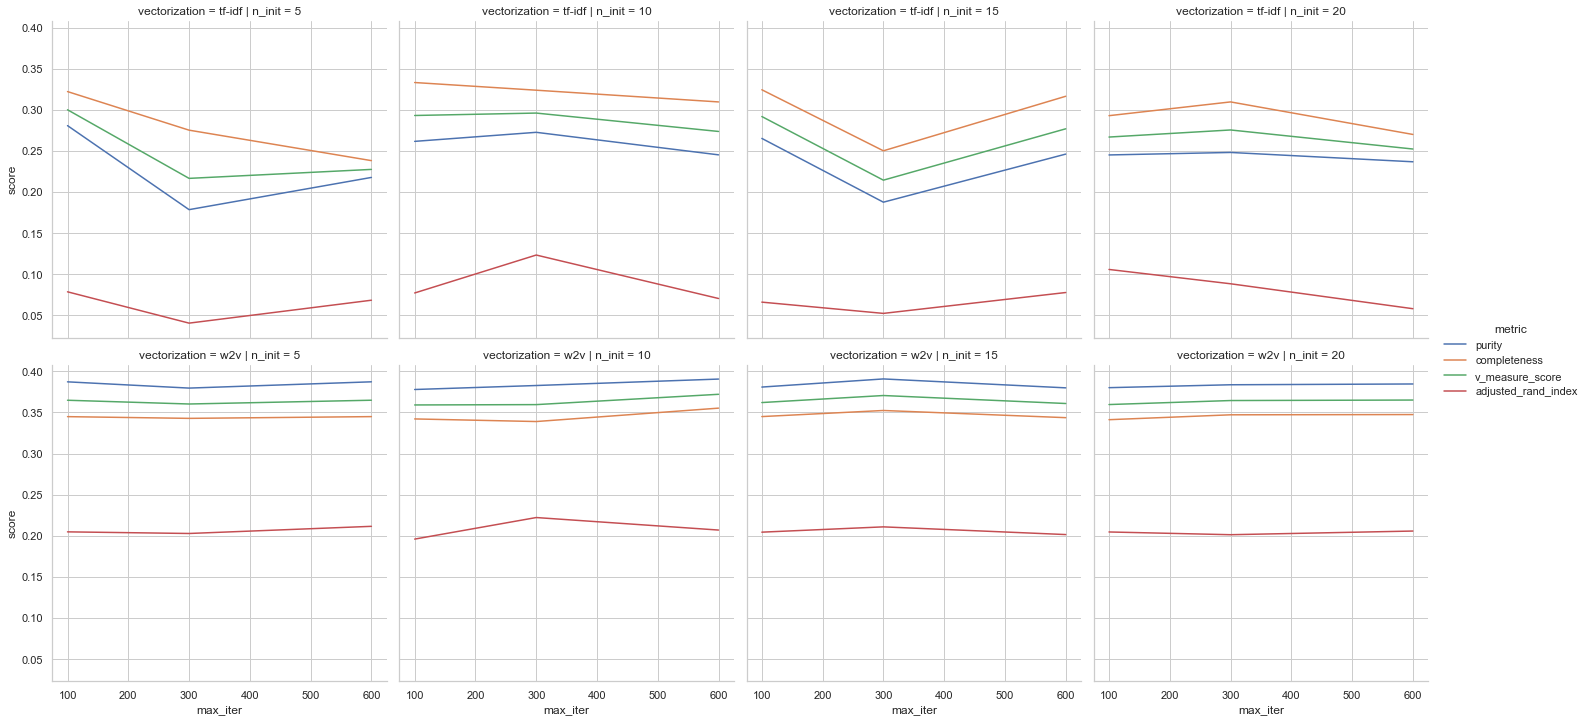

In [5]:
_ = sns.relplot(data=res[res['n_components']==13], x='max_iter', y='score', col='n_init', row='vectorization', hue="metric", kind='line' )

Finalizing clustering with `n_components=13`, `max_iter=300`, and `n_init=10`.

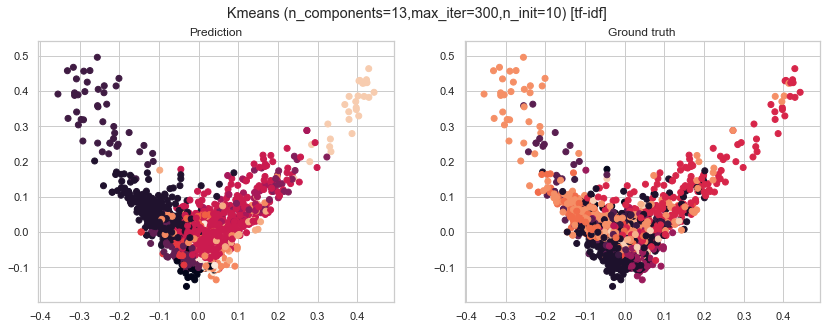

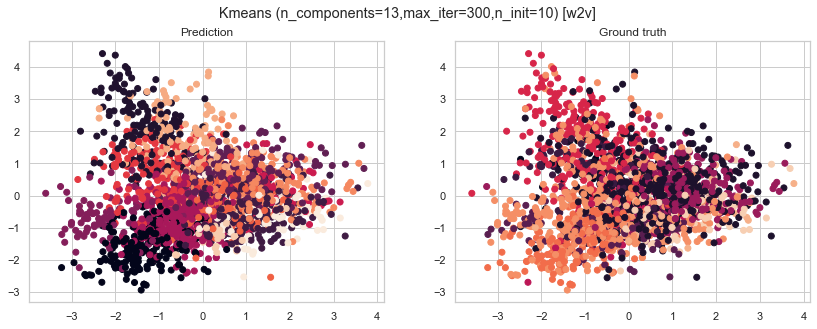

In [11]:
kmeans_res = clust.cluster(data, algorithm=clust.kmeans, tfidf=pca_tfidf, w2v=w2v, options=dict(n_components=13, max_iter=300, n_init=10), save=True)

## GMM
Evaluating hyper parameters:

In [19]:
variables = dict(n_components=list(range(2,16)), max_iter=[100, 300, 600], covariance_type=['spherical', 'tied', 'diag', 'full'])
res = clust.probe_hyperparams(clust.GMM, data=data, tfidf=pca_tfidf, w2v=w2v, variables=variables)

100%|██████████| 168/168 [01:04<00:00,  2.60it/s]


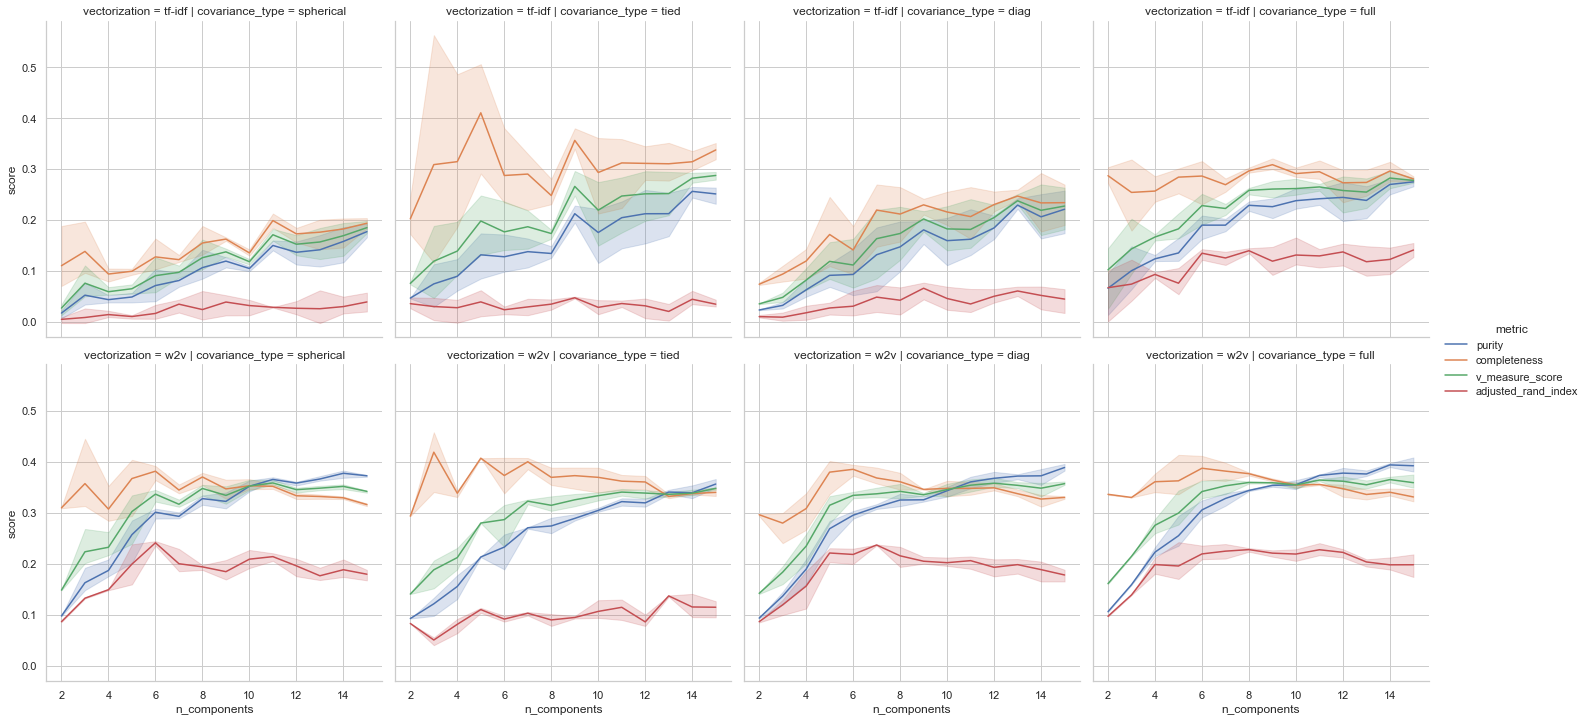

In [20]:
_ = sns.relplot(data=res, x='n_components', y='score', row='vectorization', col='covariance_type', hue="metric", kind='line' )

Evaluating `n_components=13`:

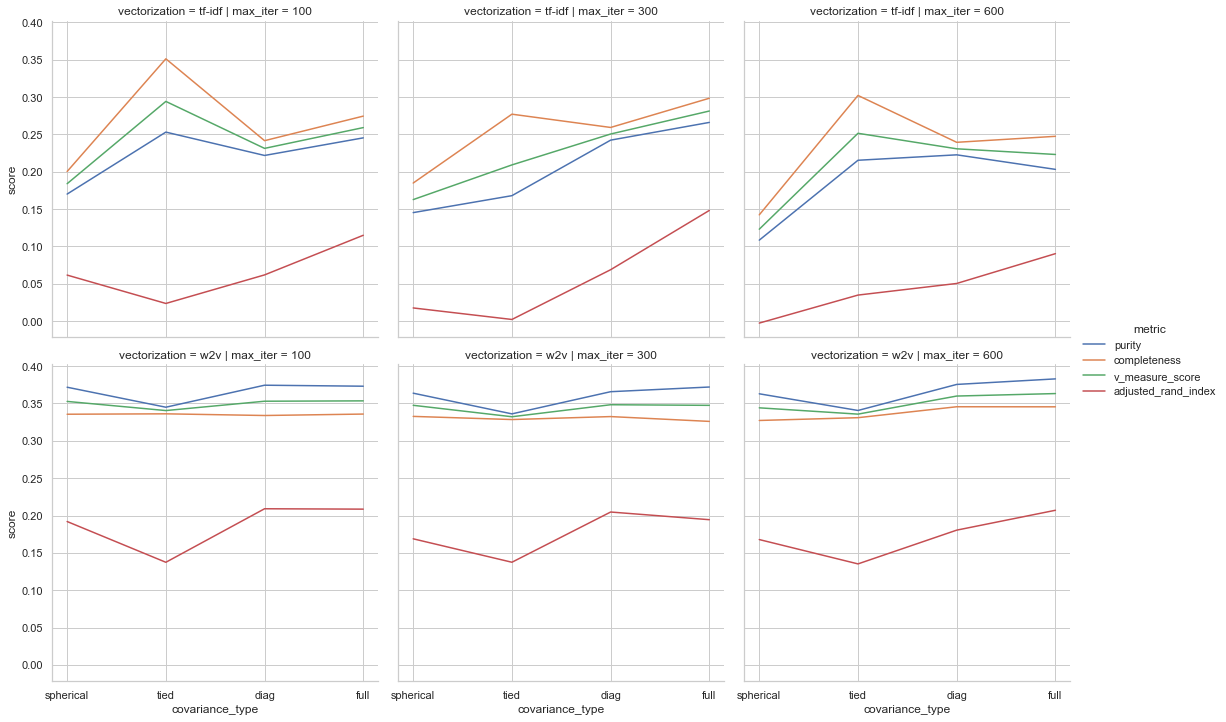

In [21]:
_ = sns.relplot(data=res[res['n_components']==13], x='covariance_type', y='score', col='max_iter', row='vectorization', hue="metric", kind='line' )

Finalizing clustering with `n_components=13`, `max_iter=600`, and `covariance_type='full'`.

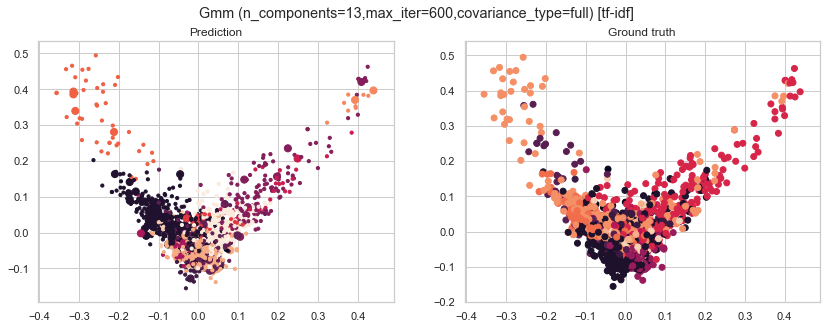

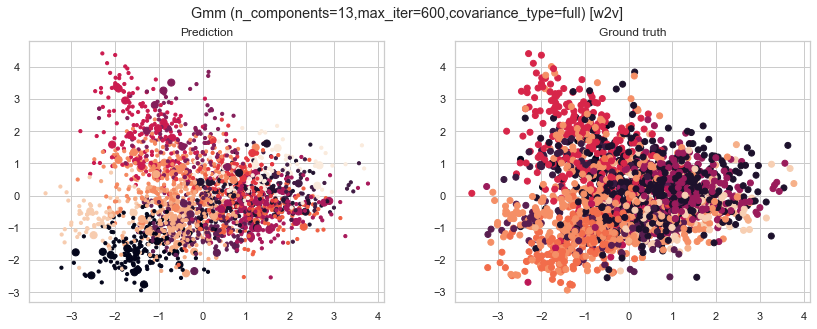

In [8]:
gmm_res = clust.cluster(data, algorithm=clust.GMM, tfidf=pca_tfidf, w2v=w2v, options=dict(n_components=13, max_iter=600, covariance_type='full'), save=True)

## Hierarchical 

In [3]:
variables = dict(
    n_components=list(range(2,16)), 
    linkage=["ward", "complete", "average", "single"], 
    affinity=["euclidean", "l1", "l2","manhattan", "cosine"]
)
res = clust.probe_hyperparams(clust.hierarchical, data=data, tfidf=pca_tfidf, w2v=w2v, variables=variables)

100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


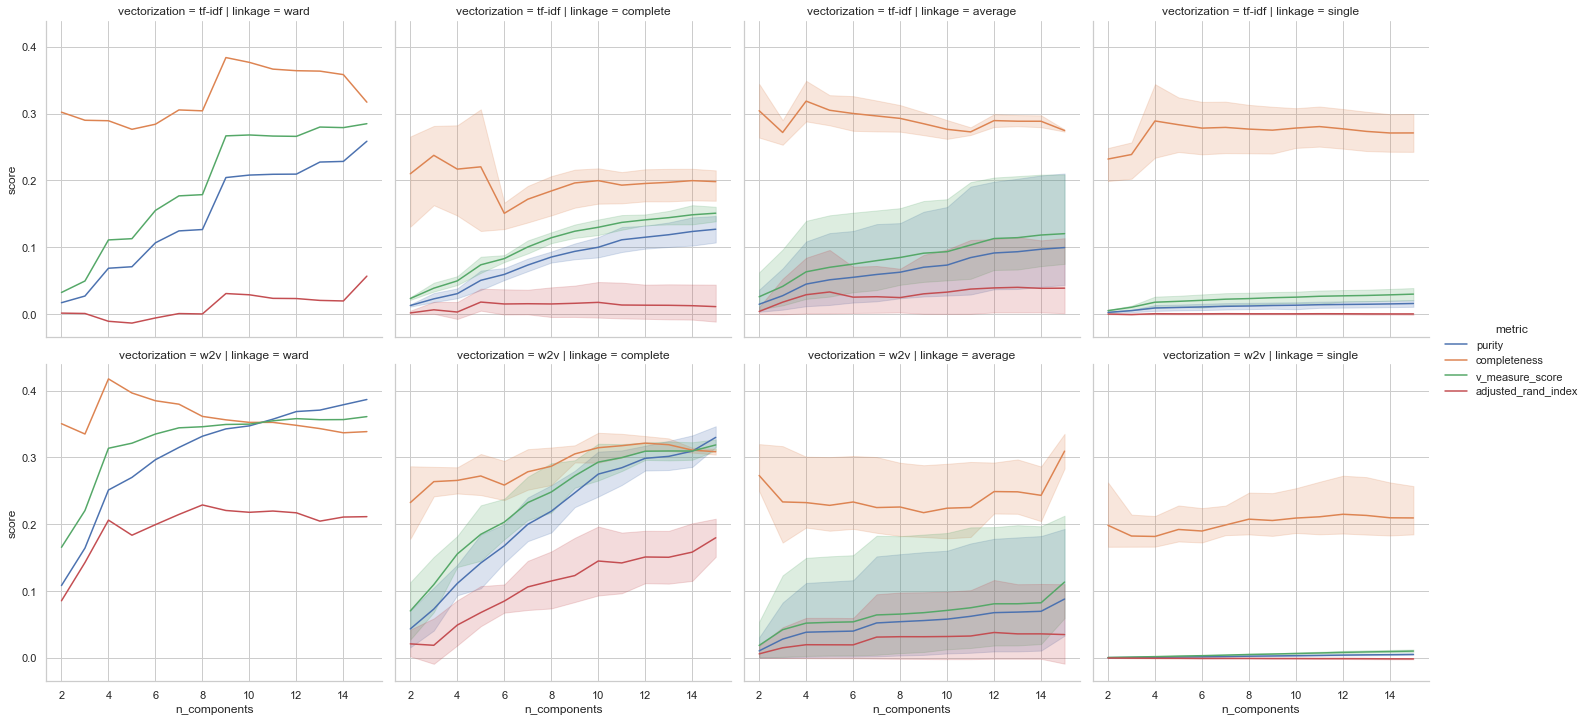

In [4]:
_ = sns.relplot(data=res, x='n_components', y='score', row='vectorization', col='linkage', hue="metric", kind='line')

Finalizing clustering with `n_components=13`, `linkage='ward'`, and `affinity='euclidean'`:

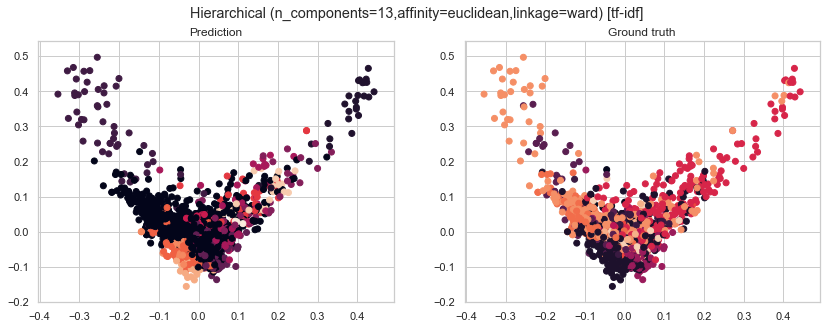

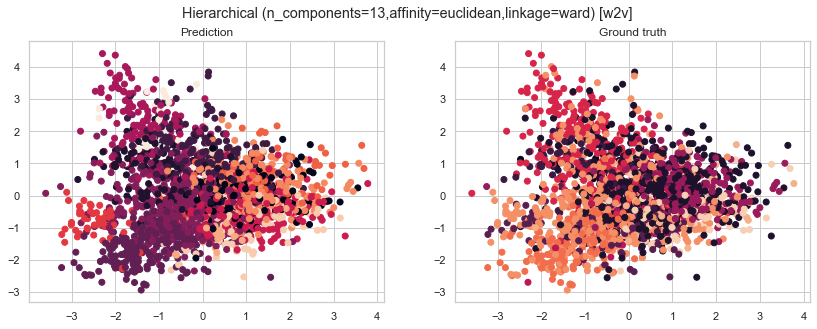

In [9]:
hierarchical_res = clust.cluster(data, algorithm=clust.hierarchical, tfidf=pca_tfidf, w2v=w2v, options=dict(n_components=13, affinity='euclidean', linkage='ward'), save=True)

# Final Evaluation

In [6]:
clust.evaluate_results(kmeans_res, gmm_res, hierarchical_res, data)

,algorithm,vectorization,purity,completeness,v_measure_score,adjusted_rand_index
0,Kmeans,tf-idf,0.240670,0.316288,0.273346,0.069982
1,Kmeans,w2v,0.240670,0.316288,0.273346,0.069982
2,Gmm,tf-idf,0.210345,0.240359,0.224352,0.111530
3,Gmm,w2v,0.210345,0.240359,0.224352,0.111530
4,Hierarchical,tf-idf,0.205231,0.359559,0.261310,0.028218
5,Hierarchical,w2v,0.205231,0.359559,0.261310,0.028218
